In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
fake_df = pd.read_csv('/content/Fake.csv')
true_df = pd.read_csv('/content/True.csv')

In [ ]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
# إضافة عمود label
fake_df['label'] = 1  # مزيف
true_df['label'] = 0  # حقيقي

# دمج البيانات
df = pd.concat([fake_df, true_df], ignore_index=True)
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)                  # إزالة الأرقام
    text = re.sub(r'[^\w\s]', '', text)               # إزالة الرموز
    text = re.sub(r'\s+', ' ', text).strip()          # إزالة المسافات الزائدة
    return text

df['full_text'] = df['title'] + " " + df['text']
df['cleaned_text'] = df['full_text'].apply(lambda x: clean_text(x))

In [ ]:
# MAX_WORDS = 5000: تعني أننا سنأخذ فقط أول 5000 كلمة الأكثر شيوعاً من النصوص.
# MAX_LEN = 100: تعني أن كل جملة ستُقصَّر أو تُمدَّ إلى 100 كلمة عند التغذية للنموذج.

# يتم إنشاء Tokenizer :
# num_words=MAX_WORDS: سيؤخذ فقط أول 5000 كلمة حسب التكرار.
# oov_token="<OOV>": يتم إضافة رمز خاص <OOV> للمفردات التي ليست ضمن الـ 5000 كلمة الأولى (OOV = Out Of Vocabulary).
# ثم نستخدم .fit_on_texts() لتحليل النصوص في العمود 'cleaned_text' من DataFrame df وإنشاء قاموس مفردات.


In [ ]:
MAX_WORDS = 5000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_text'])
#تحويل النصوص إلى تسلسلات عددية
#تحويل كل جملة نصية إلى قائمة من الأرقام (Indexes) وفق القاموس السابق
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
# يتم استخدام pad_sequences لجعل جميع الجمل بنفس الطول (maxlen=100).
# إذا كانت الجملة أطول من 100 كلمة، تُقصَّر.
# وإذا كانت أقصر، تُملأ بالصفر في البداية أو النهاية (default هو padding from beginning).
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN)

In [ ]:
X = padded_sequences
y = df['label'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
#     تحويل الكلمات (الأرقام) إلى Vectors مستمرة (128 بعدًا) .
# input_dim: عدد الكلمات (5000).
# output_dim: بُعد كل كلمة (128).
# input_length: طول الجملة (100 كلمة).
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
# طبقة من نوع Long Short-Term Memory (نوع من RNN).
# units=64: عدد الخلايا العصبية.
# return_sequences=False: لا يتم إرجاع التسلسل كاملاً، بل نأخذ فقط آخر حالة (Hidden State النهائية).
    LSTM(units=64, return_sequences=False),
# لإيقاف بعض الخلايا العصبية عشوائيًا أثناء التدريب (لمنع Overfitting ).
# 50% من الوصلات تُعطَّل في كل Epoch.
    Dropout(0.5),
# طبقة مختبئة تحتوي على 24 خلية عصبية.
# activation='relu': تفعيل غير خطي (ReLU).
    Dense(24, activation='relu'),
# الطبقة النهائية:
# activation='sigmoid': لأن هذا Binary Classification (مثال: إيجابي/سلبي).
# .Dense(1): خرج واحد (0 أو 1).
    Dense(1, activation='sigmoid')  # Binary classification
])
# optimizer='adam': خوارزمية Adam المستخدمة لتحديث أوزان النموذج.
# loss='binary_crossentropy': الدالة المناسبة للتصنيف الثنائي.
# metrics=['accuracy']: سيتم قياس الدقة (Accuracy) أثناء التدريب.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# يعرض عدد الطبقات، والأبعاد، وعدد الباراميتيرات (Parameters) في النموذج.
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 93s 159ms/step - accuracy: 0.9179 - loss: 0.2226 - val_accuracy: 0.9753 - val_loss: 0.0604
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 142s 160ms/step - accuracy: 0.9868 - loss: 0.0441 - val_accuracy: 0.9824 - val_loss: 0.0515
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 90s 161ms/step - accuracy: 0.9924 - loss: 0.0247 - val_accuracy: 0.9804 - val_loss: 0.0575
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 140s 158ms/step - accuracy: 0.9936 - loss: 0.0189 - val_accuracy: 0.9835 - val_loss: 0.0604
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 140s 155ms/step - accuracy: 0.9963 - loss: 0.0127 - val_accuracy: 0.9824 - val_loss: 0.0773


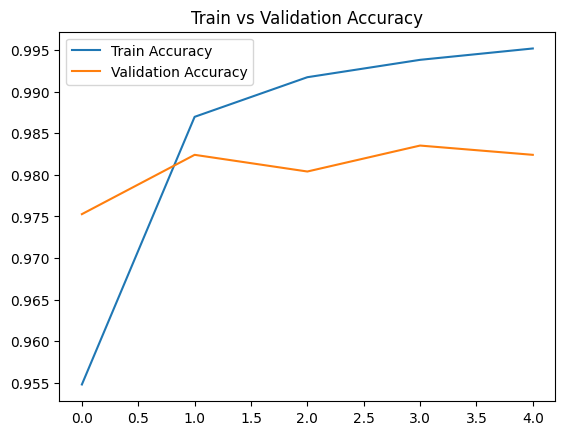

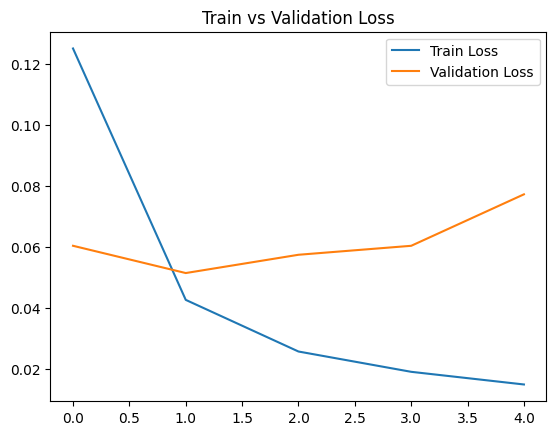

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
def predict_news(news_text):
    cleaned = clean_text(news_text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=MAX_LEN)
    pred = model.predict(pad)[0][0]
    result = "مزيف" if pred > 0.5 else "حقيقي"
    print(f"الخبر: {news_text}")
    print(f"التنبؤ: {result} | الثقة: {pred:.2f}")

In [ ]:
predict_news("The president announced new economic policies to boost growth.")
predict_news("Scientists discovered a way to live forever using bananas.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
الخبر: The president announced new economic policies to boost growth.
التنبؤ: مزيف | الثقة: 0.95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
الخبر: Scientists discovered a way to live forever using bananas.
التنبؤ: مزيف | الثقة: 1.00
